Abstract
===

This notebook intends to recreate the SimpleNet model specified in the [Lets keep it simple, Using simple architectures to outperform deeper and more complex architectures](https://arxiv.org/pdf/1608.06037v8.pdf) paper and code using PyTorch. Only the slim version of the model is replicated for use on personal computers with limited computational power. The performance of this implementation is tested against the MNIST and EMNIST handwritten digits dataset.

Preparation
===

Import relevant libraries and ensure they are recent.

In [1]:
import torch
import torchvision

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

torch: 2.1.2
torchvision: 0.16.2


Utilities
---

### Device Agnostic Code

Use CUDA on machines with Nvidia GPU, and MPS on Apple machines with M1 series chips; If neither is available, fall back to CPU.

In [2]:
%%writefile utils.py
"""
Utilities to constructing, training and testing SimpleNet using PyTorch. 
"""

import torch

def get_available_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

Overwriting utils.py


In [3]:
from utils import get_available_device

device = get_available_device()

Reproducibility
---

The following seed is used throughout this notebook.

In [4]:
SEED = 3407

A Glance at the Dataset
---

PyTorch has MNIST dataset builtin, so it's easy to download it from the Internet and use it with PyTorch.

In [5]:
from pathlib import Path
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

data_dir = Path("data")

train_dataset = MNIST(
    data_dir,
    transform=ToTensor(),
    download=True
)
test_dataset = MNIST(
    data_dir,
    train=False,
    transform=ToTensor(),
    download=True
)
classes = train_dataset.classes

len(train_dataset), len(test_dataset), len(classes)

(60000, 10000, 10)

Visualize some random images from the dataset with their labels.

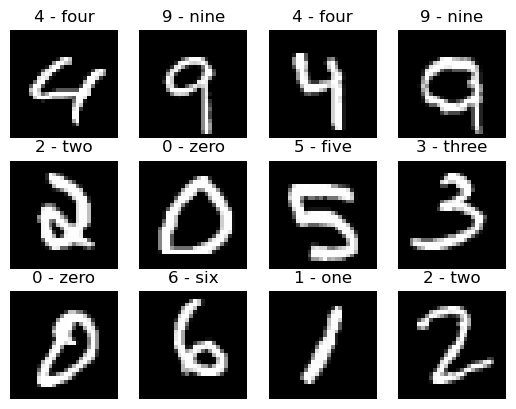

In [6]:
import math
import random
import matplotlib.pyplot as plt

def plot_images(dataset: torch.utils.data.Dataset,
                classes: list[str],
                k: int = 9,
                seed: int = SEED):
    """
    Given a dataset, pick random images and plot them.

    :param dataset: dataset to pick images from
    :param k: the number of images to pick
    :param seed: the number used to seed the random generator
    :param title_fn: transform the title with this function
    """
    random.seed(seed)
    idx = random.sample(range(len(dataset)), k=k)

    a = math.floor(math.sqrt(9))
    b = math.ceil(k / a)
    for i in range(k):
        image, target = dataset[idx[i]]
        title = f"{classes[target]}"
        plt.subplot(a, b, i+1)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(title)
        plt.axis(False)

plot_images(train_dataset, classes, k=12)
plt.show()

Build
===

The SimpleNet Slim Architecture
---

See [paper](https://arxiv.org/pdf/1608.06037v8.pdf) for a detailed description of the architecture and explanation to some design choices.

See [slim version 310K params](https://github.com/Coderx7/SimpleNet/blob/master/SimpNet_V1/Models/Slim_version_310KParams/train_test.prototxt) for details of the model architecture related to the above paper. The architecture is specified for use with [Caffe](https://caffe.berkeleyvision.org/), which is different to PyTorch in the implementation of some functionalities. Those discrepancies require extra attention.

Use [Netscope](https://ethereon.github.io/netscope/#/editor) for a visualization of the model architecture: paste in the `prototxt` file content and press <kbd>Shift</kbd>+<kbd>Enter</kbd>.

In [7]:
%%writefile simpnet.py
"""
An implementation of the SimpleNet slim version (310K params) and some helper
modules.
"""

import torch

from collections import OrderedDict
from torch import nn

Overwriting simpnet.py


The SimpleNet architecture make use of a scaling layer not built into PyTorch, so we implement it ourselves. According to the [source code](https://github.com/BVLC/caffe/blob/9b891540183ddc834a02b2bd81b31afae71b2153/src/caffe/layers/scale_layer.cpp#L36C1-L40C6) of Caffe, the layer is initialized as an identity operation if the filler parameter is not provided:

> ```
>     if (!param.has_filler()) {
>         // Default to unit (1) filler for identity operation.
>         filler_param.set_type("constant");
>         filler_param.set_value(1);
>     }
> ```

In [8]:
%%writefile -a simpnet.py

class Scale(nn.Module):
    """
    Scales input by a scalar factor and add a scalar bias to it.

    The module is intialized as an identity operation but both the factor and
    the bias term is learnable.
    """

    def __init__(self):
        super().__init__()
        self.factor = nn.Parameter(torch.ones(1), requires_grad=True)
        self.bias = nn.Parameter(torch.zeros(1), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.factor + self.bias

Appending to simpnet.py


In section 3.0.2 of the paper, it reads
> Instead of thinking in layers, think and design in group of homogeneous layers.

In this spirit, the model architecture contains a series of "blocks" with a convolution layer followed by a batch normalization layer, a scaling layer, and a reLU layer. To allow easy creation of those blocks, we encapsulate it in a Python class.

One thing to note is that the momentum parameter in PyTorch batch normalization layer is not the same as that in Caffe. In [Caffe](https://github.com/BVLC/caffe/blob/9b891540183ddc834a02b2bd81b31afae71b2153/src/caffe/proto/caffe.proto#L538-L541),
> Each iteration updates the moving average $S_{t-1}$ with the current mean $Y_t$ by $S_t = (1-\beta)Y_t + \beta \cdot S_{t-1}$, where $\beta$ is the moving_average_fraction parameter.

However, in [PyTorch][ref],
> Mathematically, the update rule for running statistics here is $\hat{x}_\text{new} = (1 - \text{momentum}) \times \hat{x} + \text{momentum} \times x_t$, $\hat{x}$ is the estimated statistic and $x_t$ is the new observed value.

[ref]: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d:~:text=Mathematically%2C%20the%20update,new%20observed%20value.

In [9]:
%%writefile -a simpnet.py

class SimpnetBlock(nn.Module):
    """
    A group of homogeneous layers used in SimpleNet.

    It contains a 3x3 convolution that can be initialized using either Xavier or
    Gaussian normal, followed by a batch normalization layer, a scaling layer,
    and a reLU layer.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 weight_filler_type="xavier"
                 ):
        super().__init__()
        
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,  # num_output
            kernel_size=3,              # kernel_size
            stride=1,                   # stride
            padding="same"              # pad
        )

        # weight_filler
        if weight_filler_type == "xavier":
            nn.init.xavier_normal_(self.conv.weight)
        elif weight_filler_type == "gaussian":
            nn.init.normal_(self.conv.weight, std=0.01)
        else:
            raise ValueError(f"invalid weight filler type {weight_filler_type}")
        
        self.bn = nn.BatchNorm2d(
            num_features=out_channels,  # num_output
            momentum=0.05,              # 1 - moving_average_fraction
            affine=False                # param
        )
        self.scale = Scale()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.relu(self.scale(self.bn(self.conv(x))))

Appending to simpnet.py


Section 3.1 of the paper claims
>  Preferably use 1×1 kernels at the end of the network...

The final blocks of the architecture each consists of a convolution layer followed by only a reLU layer. The bias is initialized to zeroes.

In [10]:
%%writefile -a simpnet.py

class SimpnetCCCP(nn.Module):
    """
    A group of layers used at the end of SimpleNet.

    It consists of a convolution layer with zero-initialized bias followed by a
    reLU layer.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=1,
                 padding=0
                 ):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding
        )
        nn.init.constant_(self.conv.bias, 0)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.relu(self.conv(x))

Appending to simpnet.py


From the above components, one can construct the full SimpleNet model. For faster computation on personal machines, the implemented model is the "slimmest" SimpleNet model in the paper with only 310K parameters.

Note that some of the convolution layers later in the model has
> ```
> param {
>     lr_mult: 1
>     decay_mult: 1
> }
> param {
>     lr_mult: 2
>     decay_mult: 0
> }
> ```

In PyTorch, this has to be specified in the `params` parameter when instantiating an `Optimizer`. This implementation includes a method for creating such an optimizer with learning rate and decay multiplier correctly configured.

In [11]:
%%writefile -a simpnet.py

class SimpnetSlim310K(nn.Module):
    """
    The slimmest SimpleNet with only 310K parameters.
    """

    def __init__(self, in_channels, out_features, ip_features=64):
        super().__init__()
        self.features = nn.Sequential(OrderedDict([
            ("block1", SimpnetBlock(in_channels=in_channels,
                                    out_channels=64)),
            ("block1_0", SimpnetBlock(in_channels=64,
                                      out_channels=32)),
            ("block2", SimpnetBlock(in_channels=32,
                                    out_channels=32,
                                    weight_filler_type="gaussian")),
            ("block2_1", SimpnetBlock(in_channels=32,
                                      out_channels=32,
                                      weight_filler_type="gaussian")),
            ("pool2_1", nn.MaxPool2d(kernel_size=2)),
            ("block2_2", SimpnetBlock(in_channels=32,
                                      out_channels=32,
                                      weight_filler_type="gaussian")),
            ("block3", SimpnetBlock(in_channels=32,
                                    out_channels=32)),
            ("conv4", nn.Conv2d(in_channels=32,
                                out_channels=64,
                                kernel_size=3,
                                stride=1,
                                padding="same")),
            ("pool4", nn.MaxPool2d(kernel_size=2)),
            ("bn4", nn.BatchNorm2d(num_features=64,
                                   momentum=0.05,
                                   affine=False)),
            ("scale4", Scale()),
            ("relu4", nn.ReLU(inplace=True)),
            ("block4_1", SimpnetBlock(in_channels=64,
                                      out_channels=64)),
            ("block4_2", SimpnetBlock(in_channels=64,
                                      out_channels=64)),
            ("pool4_2", nn.MaxPool2d(kernel_size=2)),
            ("block4_0", SimpnetBlock(in_channels=64,
                                      out_channels=128)),
            ("cccp4", SimpnetCCCP(in_channels=128,
                                  out_channels=256)),
            ("cccp5", SimpnetCCCP(in_channels=256,
                                  out_channels=64)),
            ("poolcp5", nn.MaxPool2d(kernel_size=2)),
            ("cccp6", SimpnetCCCP(in_channels=64,
                                  out_channels=64,
                                  kernel_size=3,
                                  padding=1)),
            ("poolcp6", nn.MaxPool2d(kernel_size=2)),
        ]))

        self.ip1 = nn.Linear(
            in_features=ip_features,
            out_features=out_features
        )
        nn.init.xavier_normal_(self.ip1.weight)
        nn.init.constant_(self.ip1.bias, 0)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            self.ip1
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.features(x))

    def get_optimizer(self,
                      optimizer_cls: type[torch.optim.Optimizer],
                      **kwargs
                      ) -> torch.optim.Optimizer:
        """
        Creates an optimizer with learning rate and weight decay correctly
        configured for this model.

        :param optimizer_cls: the optimizer class to instantiate with
        :param kwargs: the keyword arguments to pass to the optimizer class (must contain `lr`)
        :returns: an optimizer instance correctly configured for this model
        """
        lr = kwargs["lr"]
        params = set(self.parameters())
        custom = {
            self.features.cccp4.conv.bias,
            self.features.cccp5.conv.bias,
            self.features.cccp6.conv.bias,
        }
        optimizer = optimizer_cls(
            [
                {"params": list(params - custom)},
                {"params": list(custom), "lr": 2 * lr, "weight_decay": 0}
            ],
            **kwargs
        )

        return optimizer

Appending to simpnet.py


Summarize the model architecture with test input size:
- 128 samples per batch
- 1 color channel
- 32 pixels wide
- 32 pixels high

The test image is upscaled to 32 by 32 (instead of the original 28 by 28) because otherwise the tensor would become zero-sized after going through the deep network and produces an error.

In [12]:
from torchinfo import summary
from simpnet import SimpnetSlim310K

simpnet_slim = SimpnetSlim310K(
    in_channels=1,
    out_features=len(classes)
)
summary(simpnet_slim, (128, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SimpnetSlim310K                          [128, 10]                 --
├─Sequential: 1-1                        [128, 64, 1, 1]           --
│    └─SimpnetBlock: 2-1                 [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         640
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         --
│    │    └─Scale: 3-3                   [128, 64, 32, 32]         2
│    │    └─ReLU: 3-4                    [128, 64, 32, 32]         --
│    └─SimpnetBlock: 2-2                 [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         18,464
│    │    └─BatchNorm2d: 3-6             [128, 32, 32, 32]         --
│    │    └─Scale: 3-7                   [128, 32, 32, 32]         2
│    │    └─ReLU: 3-8                    [128, 32, 32, 32]         --
│    └─SimpnetBlock: 2-3                 [128, 32, 32, 32]         --
│    │    └─

Transformation and Data Loader
---

As explained above, the images should be upscaled to at least 32 by 32 to prevent a runtime error.

In [13]:
from torchvision.transforms import Compose, Resize

simple_transform = Compose([
    Resize((32, 32)),
    ToTensor()
])
train_dataset = MNIST(
    data_dir,
    transform=simple_transform,
    download=True
)
test_dataset = MNIST(
    data_dir,
    train=False,
    transform=simple_transform,
    download=True
)
classes = train_dataset.classes

Create data loader for faster computation in batches.

In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128
NUM_WORKERS = 0

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

len(train_dataloader), len(test_dataloader)

(469, 79)

## Train and Test Loop

In [15]:
%%writefile train.py
"""
Train and test PyTorch models with data loaders.
"""

import torch

from pathlib import Path

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

from utils import get_available_device

device = get_available_device()

def train_one_epoch(model: nn.Module,
                    dataloader: DataLoader,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    device: torch.device = device,
                    ):
    model.to(device)
    model.train()

    running_loss = 0.
    running_acc = 0.

    for i, data in enumerate(tqdm(dataloader,
                                  desc="Train",
                                  leave=False,
                                  unit="batch")):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_acc += correct / len(labels)

    return running_loss / len(dataloader), running_acc / len(dataloader)

def test_one_epoch(model: nn.Module,
                   dataloader: DataLoader,
                   loss_fn: nn.Module,
                   device: torch.device = device,
                   ):
    model.to(device)
    model.eval()

    running_loss = 0.
    running_acc = 0.

    with torch.inference_mode():
        for i, data in enumerate(tqdm(dataloader,
                                      desc="Test",
                                      leave=False,
                                      unit="batch")):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)    
            loss = loss_fn(outputs, labels)
            
            running_loss += loss.item()
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_acc += correct / len(labels)

    return running_loss / len(dataloader), running_acc / len(dataloader)

def train_test_loop(model: nn.Module,
                    train_dataloader: DataLoader,
                    test_dataloader: DataLoader,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    *,
                    epochs: int = 5,
                    device: torch.device = device,
                    print: bool = True,
                    writer: SummaryWriter = None,
                    save_to = None
                    ):
    """
    Train and test a model using the given train and test data loaders, loss
    function, and optimizer.

    :param model: model to train and test
    :param train_dataloader: data loader for training
    :param test_dataloader: data loader for testing
    :param loss_fn: loss function
    :param optimizer: optimizer
    :param epochs: train for this many iterations
    :param device: device to train the model on
    :param print: print loss and accuracy to `stdout`
    :param writer: a summary writer to write statistics to
    :param save_to: a path to save the model with highest accuracy
    """    
    if save_to is not None:
        save_to = Path(save_to)
        save_to.parent.mkdir(parents=True, exist_ok=True)

    best_test_acc = 0
    for epoch in tqdm(range(1, epochs + 1), unit="epoch"):
        avg_train_loss, avg_train_acc = train_one_epoch(
            model,
            train_dataloader,
            loss_fn,
            optimizer,
            device
        )

        avg_test_loss, avg_test_acc = test_one_epoch(
            model,
            test_dataloader,
            loss_fn,
            device
        )

        if print:
            tqdm.write(
                f"epoch: {epoch:5d} |"
                f" train loss: {avg_train_loss:.3f} |"
                f" train accuracy: {avg_train_acc:.1%} |"
                f" test loss: {avg_test_loss:.3f} |"
                f" test accuracy: {avg_test_acc:.1%}"
            )
        
        if writer is not None:
            writer.add_scalars(
                "Training vs. Test Loss",
                {"Training": avg_train_loss, "Test": avg_test_loss},
                epoch
            )
            writer.add_scalars(
                "Training vs. Test Accuracy",
                {"Training": avg_train_acc, "Test": avg_test_acc},
                epoch
            )
            writer.flush()

        if save_to is not None and avg_test_acc > best_test_acc:
            best_test_acc = avg_test_acc
            torch.save(model.state_dict(), save_to)

Overwriting train.py


In [16]:
import math

from torch import nn
from torch.utils.tensorboard import SummaryWriter

from train import train_test_loop

epochs = 50
name = "simpnet_slim_310k"

runs_dir = Path("runs")
models_dir = Path("models")

torch.manual_seed(SEED)

simpnet_slim = SimpnetSlim310K(1, len(classes))
loss_fn = nn.CrossEntropyLoss()
optimizer = simpnet_slim.get_optimizer(
    torch.optim.RMSprop,
    momentum=0.9,
    eps=math.sqrt(0.001),
    lr=0.0000195,
    weight_decay=0.0981
)

train_test_loop(
    simpnet_slim,
    train_dataloader,
    test_dataloader,
    loss_fn,
    optimizer,
    epochs=epochs,
    print=False,
    writer=SummaryWriter(runs_dir / name),
    save_to=models_dir / f"{name}.pt"
)

  0%|          | 0/50 [00:00<?, ?epoch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Train:   0%|          | 0/469 [00:00<?, ?batch/s]

Test:   0%|          | 0/79 [00:00<?, ?batch/s]

Predict
===

Load the Best Model
---

The best performing model, i.e., the model with highest accuracy is saved to the `models` directory during training.

In [17]:
simpnet_slim = SimpnetSlim310K(1, len(classes))
simpnet_slim.load_state_dict(torch.load(models_dir / f"{name}.pt"))

<All keys matched successfully>

Predict on MNIST
---

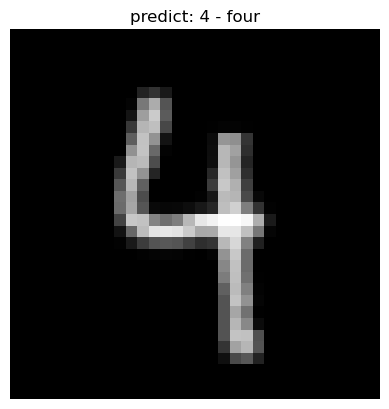

In [18]:
from typing import List, Optional

from PIL import Image
from torch import nn
from torchvision.transforms import Resize, Grayscale

def plot_predict(model: nn.Module,
                 image,
                 classes: list,
                 *,
                 ax: Optional[plt.Axes] = None,
                 device=device):
    """
    Predict an image using a given model and plot them.
    """
    transform = Compose([
        Resize((32, 32)),
        ToTensor(),
        Grayscale()
    ])
    if not isinstance(image, torch.Tensor):
        image = transform(image)
    if ax is None:
        ax = plt.subplot()

    model.to(device)
    model.eval()
    with torch.inference_mode():
        logits = model(image.unsqueeze(0).to(device))
        probs = torch.softmax(logits, dim=1)
        class_ = classes[torch.argmax(probs, dim=1)]

    ax.imshow(image.permute(1, 2, 0), cmap="gray")
    ax.set_title(f"predict: {class_}")
    ax.axis(False)

    return probs, class_

random.seed(SEED)
idx = random.randrange(len(test_dataset))
image = test_dataset[idx][0]
probs, class_ = plot_predict(simpnet_slim, image, classes)
plt.show()

In [19]:
import pandas as pd

from tqdm.auto import tqdm

def prediction_dataframe(model, dataset, classes, device=device):
    """
    Predict all images in a given dataset using a given model and produce a
    data frame containing the prediction, label and probabilities the model
    thinks that they are for both.
    """

    model.to(device)
    model.eval()

    results = []
    with torch.inference_mode():
        for image, label in (tqdm(dataset, desc="Predict", unit="sample")):
            logits = model(image.unsqueeze(0).to(device))
            probs = torch.softmax(logits, dim=1)
            predict = torch.argmax(probs, dim=1).item()
            pred_prob = probs[0, predict].item()
            label_prob = probs[0, label].item()
            results.append([
                classes[predict],
                pred_prob,
                classes[label],
                label_prob
            ])

    return pd.DataFrame(
        results,
        columns=[
            "prediction",
            "predict_probability",
            "label",
            "label_probability"
        ]
    )

pred_df = prediction_dataframe(simpnet_slim, test_dataset, classes)
pred_df

Predict:   0%|          | 0/10000 [00:00<?, ?sample/s]

,prediction,predict_probability,label,label_probability
0,7 - seven,0.978806,7 - seven,0.978806
1,2 - two,0.982585,2 - two,0.982585
2,1 - one,0.967582,1 - one,0.967582
3,0 - zero,0.956906,0 - zero,0.956906
4,4 - four,0.974413,4 - four,0.974413
...,...,...,...,...
9995,2 - two,0.983357,2 - two,0.983357
9996,3 - three,0.979877,3 - three,0.979877
9997,4 - four,0.971314,4 - four,0.971314
9998,5 - five,0.980245,5 - five,0.980245


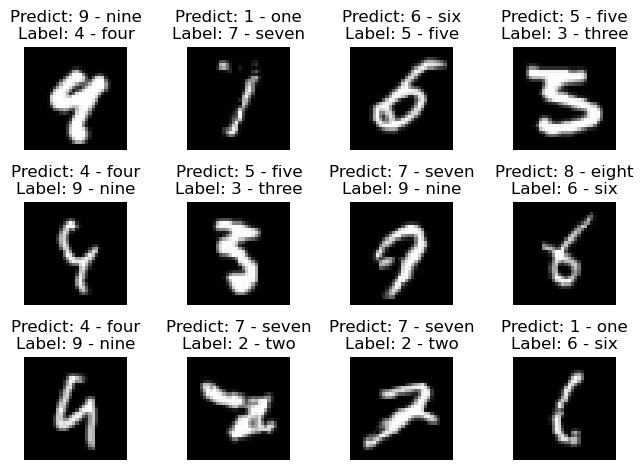

In [20]:
def plot_worst_predictions(pred_df: pd.DataFrame, dataset, n=9):
    """
    Plot the worst predictions in a given prediction DataFrame.

    The wrong predictions with the highest probabilities are considered the most
    incorrect predictions.

    :param pred_df: the data frame containing the prediction results, see :meth:`prediction_dataframe`
    :param dataset: the dataset used for the model predictions
    :param int n: the number of worst predictions to plot
    """
    wrong_df = pred_df[pred_df["prediction"] != pred_df["label"]]
    worst_df = wrong_df.sort_values(
        "predict_probability",
        ascending=False
    ).head(n)
    a = math.floor(math.sqrt(9))
    b = math.ceil(n / a)
    for i, row in enumerate(worst_df.itertuples()):
        image, target = dataset[row.Index]
        plt.subplot(a, b, i + 1)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(
            f"Predict: {row.prediction}\n"
            f"Label: {row.label}",
        )
        plt.axis(False)
    plt.tight_layout(w_pad=3)

plot_worst_predictions(pred_df, test_dataset, n=12)

EMNIST Digits
===

Preparation
---

EMNIST contains more handwritten digits data than the MNIST dataset.

Note that the data in EMNIST are transposed. Even though this won't hinder the learning process of the SimpleNet, it makes it harder for use human to visualize and also to apply this model to MNIST. Therefore, a transpose transformation is applied to the EMNIST dataset before training and testing.

In [21]:
from torchvision.datasets import EMNIST

class Transpose:
    """
    Given an image in CHW, transpose it into CWH.
    """

    def __call__(self, x: torch.Tensor):
        return torch.transpose(x, 1, 2)

emnist_transform = Compose([
    Resize((32, 32)),
    ToTensor(),
    Transpose()
])

emnist_train_dataset = EMNIST(
    data_dir,
    "digits",
    train=True,
    transform=emnist_transform,
    download=True
)
emnist_test_dataset = EMNIST(
    data_dir,
    "digits",
    train=False,
    transform=emnist_transform,
    download=True
)

len(emnist_train_dataset), len(emnist_test_dataset)

(240000, 40000)

The classes are named differently in the EMNIST dataset.

In [22]:
emnist_classes = emnist_test_dataset.classes
emnist_classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Visualize a random subset of the images in the EMNIST digits dataset.

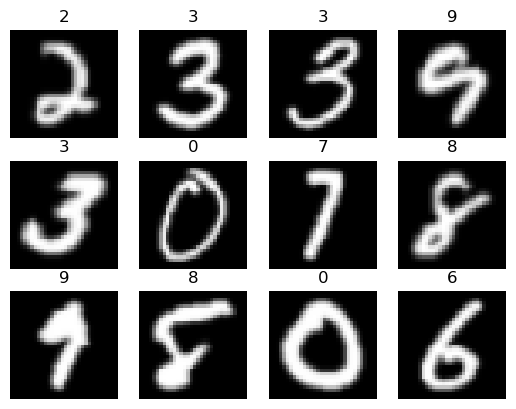

In [23]:
plot_images(emnist_test_dataset, emnist_classes, k=12)
plt.show()

Create batched data loader for efficient training and testing.

In [24]:
emnist_train_dataloader = DataLoader(
    emnist_train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

emnist_test_dataloader = DataLoader(
    emnist_test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

len(emnist_train_dataloader), len(emnist_test_dataloader)

(1875, 313)

Training and Evaluation
---

Train and test the Slim 310K version of the SimpleNet model using EMNSIT digits dataset.

In [25]:
name = "simpnet_slim_310k_emnist"
epochs = 50

simpnet_slim_emnist = SimpnetSlim310K(1, len(classes))
loss_fn = nn.CrossEntropyLoss()
optimizer = simpnet_slim_emnist.get_optimizer(
    torch.optim.RMSprop,
    momentum=0.9,
    eps=math.sqrt(0.001),
    lr=0.0000195,
    weight_decay=0.0981
)

torch.manual_seed(SEED)
train_test_loop(
    simpnet_slim_emnist,
    emnist_train_dataloader,
    emnist_test_dataloader,
    loss_fn,
    optimizer,
    epochs=epochs,
    print=False,
    writer=SummaryWriter(runs_dir / name),
    save_to=models_dir / f"{name}.pt"
)

  0%|          | 0/50 [00:00<?, ?epoch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Prediction
---

Load the best performing model saved during training.

In [26]:
simpnet_slim_emnist = SimpnetSlim310K(1, len(classes))
simpnet_slim_emnist.load_state_dict(torch.load(models_dir / f"{name}.pt"))

<All keys matched successfully>

Predict on the whole test dataset and display the worst predictions.

Predict:   0%|          | 0/40000 [00:00<?, ?sample/s]

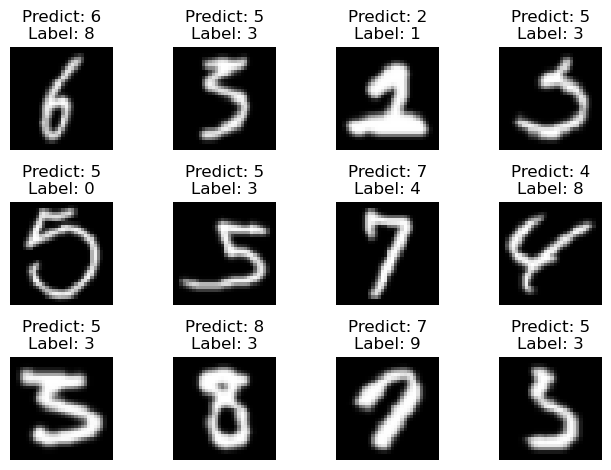

In [27]:
torch.manual_seed(SEED)

pred_df = prediction_dataframe(
    simpnet_slim_emnist,
    emnist_test_dataset,
    emnist_classes
)
plot_worst_predictions(pred_df, emnist_test_dataset, n = 12)